In [1]:
import pandas as pd
# loads X train dataset (features of each instance)
x_train = pd.read_csv('CompleteDataSet/x_train_all.csv')
# load Y train dataset (classes of each instance)
y_train=pd.read_csv('CompleteDataSet/y_train_all.csv')

x_train.shape

(9690, 2304)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score



In [3]:
def silhouetteScore(data, clustersdata):
    silhouette_avg = silhouette_score(data, clustersdata)
    print("Silhouette Score:", silhouette_avg)

### Create Diff kinds of dataframe


##### PCA

In [4]:
n_components = 1500  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x_train)

pca1000 = PCA(n_components=1000)
X_pca1000 = pca1000.fit_transform(x_train)

pca2000 = PCA(n_components=2000)
X_pca2000 = pca2000.fit_transform(x_train)

def PCAOnData(data,components):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(data)
    df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    return df_pca

##### Pre-Processed

In [5]:
processed_df = pd.read_csv('processed_df.csv')

##### Infra-Red


In [6]:
def grayscale_to_infrared(grayscale_image):
    row = np.array(grayscale_image, dtype=np.uint8)
    color_map = plt.get_cmap('hot')
    normalized_image = row / 255.0
    infrared_image = (color_map(normalized_image)[:, :, 0] * 255).astype(np.uint8)
    return infrared_image.flatten()

In [7]:
infrared_original = []

for i, idx in enumerate(x_train.index):
    original_image = x_train.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_org = pd.DataFrame(infrared_original)
infrared_df_org.shape

(9690, 2304)

### Visualise


In [8]:
def TSNEplots(data,clusterlabels,title):
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)

    dataTSNE = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels, s=20)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

### Create Clustering Algos


##### Agglomerative Clustering

In [9]:
def aggfunc(data, k):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    clusters = agg_clustering.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [10]:
agg_10_clusters_labels = aggfunc(x_train,10)

In [11]:
silhouetteScore(x_train,agg_10_clusters_labels)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


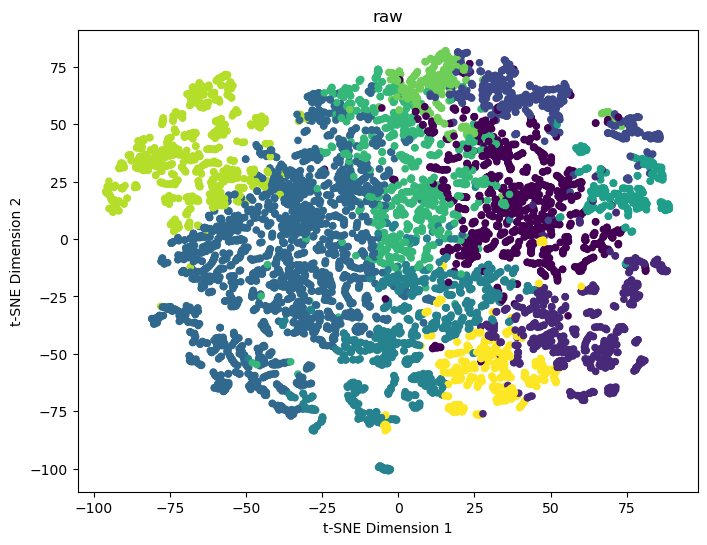

In [12]:
TSNEplots(x_train.to_numpy(),agg_10_clusters_labels,"raw")

In [13]:
agg_10_clusters_labels_infra = aggfunc(infrared_df_org,10)

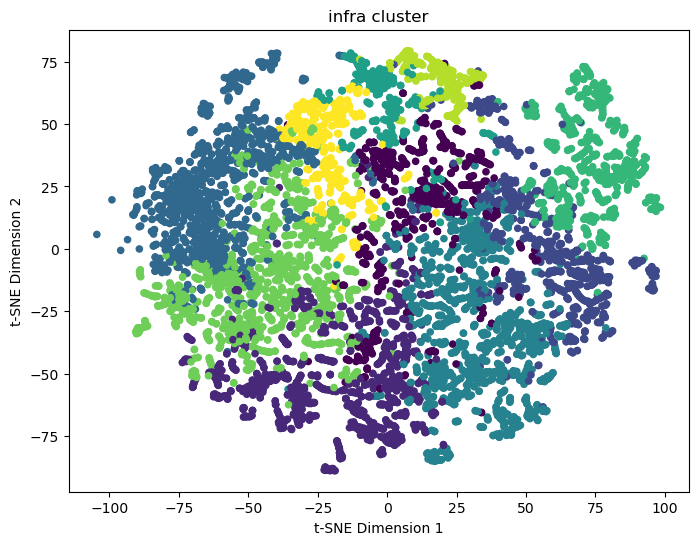

In [14]:
TSNEplots(infrared_df_org,agg_10_clusters_labels_infra,"infra cluster")

In [15]:
silhouetteScore(infrared_df_org,agg_10_clusters_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.10424093019253086


In [16]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in x_train.columns]
infrared_copy = x_train.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_no_outliers = infrared_copy.drop(outlier_indices)
infra_no_outliers.to_csv('x_train_no_outliers.csv',index=False)

outlier_indices_df = pd.DataFrame({'outlier_index': outlier_indices})

outlier_indices_df.to_csv('outlier_indices.csv', index=False)

In [17]:
clusters_infra_no_outliers = aggfunc(infra_no_outliers, 10)
silhouetteScore(infra_no_outliers,clusters_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


In [18]:
mean=infra_no_outliers.mean()
std=infra_no_outliers.std()
infra_norm=(infra_no_outliers-mean)/std

In [19]:
clusters = aggfunc(infra_norm, 10)
silhouetteScore(infra_norm,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08682438504803372


In [20]:
mean=x_train.mean()
std=x_train.std()
x_norm=(x_train-mean)/std

In [21]:
infrared_original = []

for i, idx in enumerate(x_norm.index):
    original_image = x_norm.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_norm = pd.DataFrame(infrared_original)
infrared_df_norm.shape

(9690, 2304)

In [23]:
clusters = aggfunc(infrared_df_norm, 10)
silhouetteScore(infrared_df_norm,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46254749032402126


In [24]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in infrared_df_norm.columns]
infrared_copy = infrared_df_norm.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_norm_no_outliers = infrared_copy.drop(outlier_indices)

In [25]:
clusters = aggfunc(infra_norm_no_outliers, 10)
silhouetteScore(infra_norm_no_outliers,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6497470524049589


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.5993403350000828


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.602393660684713


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4670504658963724


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46815855705203424


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.47154068178230957


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.465090706813612


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4646668602861849


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46346324923462934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4633759228662821


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46489932057515354


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4657825950302391


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46661148018797066


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4672142189019768


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46720906128180933


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4678028840976886


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46757377895053726


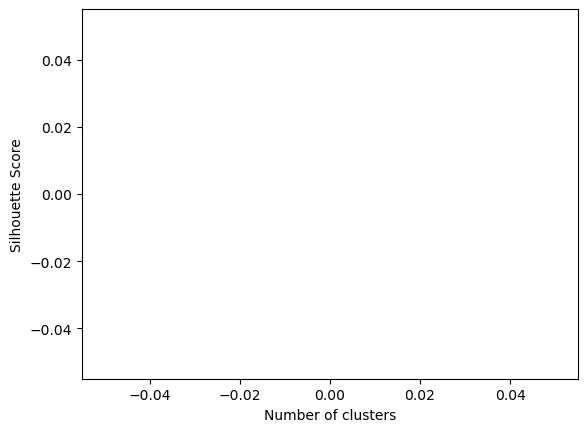

In [28]:
silhouetteScoreAll = [] 
for i in range(2, 21): 
    
    clustersLabels = aggfunc(infra_norm_no_outliers,i)
    silhouetteScoreAll.append(silhouetteScore(infra_norm_no_outliers,clustersLabels))

plt.plot(range(2, 21), silhouetteScoreAll)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
plt.show()

In [29]:
clusters = aggfunc(infra_norm_no_outliers, 2)
silhouetteScore(infra_norm_no_outliers,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


In [30]:
import cv2
def apply_gaussian_blur(row, kernel_size=(5, 5), sigma=0):
    row = np.array(row, dtype=np.uint8)
    row = cv2.GaussianBlur(row, kernel_size, sigma)
    return row

def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

In [31]:
infrared_prep = []

for index, row in infra_norm_no_outliers.iterrows():
    image_data = row.values
    gaussian_image = apply_gaussian_blur(image_data)
    equalized_image = apply_clahe(gaussian_image)
    infrared_prep.append(equalized_image.flatten())

prepped_infrared_df = pd.DataFrame(infrared_prep)
prepped_infrared_df.shape

(9593, 2304)

In [32]:
clusters = aggfunc(prepped_infrared_df, 10)
silhouetteScore(prepped_infrared_df,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.44571711187269836


In [33]:
clusters = aggfunc(prepped_infrared_df, 2)
silhouetteScore(prepped_infrared_df,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


In [34]:
df_pca_50 = PCAOnData(prepped_infrared_df, 50)
clusters_pca50 = aggfunc(df_pca_50, 10)
silhouetteScore(df_pca_50, clusters_pca50)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46246735435572783


In [35]:
image_df = prepped_infrared_df.copy()

In [36]:
import cv2
import pandas as pd
import numpy as np

# Assuming 'image_df' is your DataFrame with each row as an image

# Create a list to store the Fourier Transformed images
fourier_transformed_images = []

# Iterate through each row (image) in the DataFrame
for index, row in image_df.iterrows():
    # Convert the row (image) to a NumPy array
    image = row.values.reshape(48, 48)

    # Apply DFT to the image
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero frequency components to the center
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1])

    # Flatten the magnitude spectrum to 1D
    flattened_magnitude_spectrum = magnitude_spectrum.flatten()

    # Append the flattened magnitude spectrum to the list
    fourier_transformed_images.append(flattened_magnitude_spectrum)

# Create a new DataFrame from the Fourier Transformed images
fourier_df = pd.DataFrame(fourier_transformed_images)

# The 'fourier_df' DataFrame now contains the magnitude spectra of the images


In [37]:
pca_50 = PCAOnData(fourier_df, 50)
clusters = aggfunc(pca_50, 10)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.45071933


In [38]:
image_df = fourier_df.copy()

In [39]:
import numpy as np
import cv2  # Make sure you have OpenCV installed

# Define a function to emphasize lower frequencies using DCT
def emphasize_lower_frequencies(image, keep_ratio=0.1):
    # Apply DCT
    dct = cv2.dct(np.float32(image))

    # Determine the threshold to retain keep_ratio of the coefficients
    sorted_dct = np.sort(np.abs(dct), axis=None)
    threshold = sorted_dct[int(keep_ratio * sorted_dct.size)]

    # Zero out high-frequency coefficients
    dct[np.abs(dct) < threshold] = 0

    # Apply inverse DCT to get the filtered image
    filtered_image = cv2.idct(dct)
    
    return filtered_image


In [40]:
image_df = prepped_infrared_df.copy()

filtered_images = []

for index, row in image_df.iterrows():
    image_data = row.values
    filtered_image = emphasize_lower_frequencies(image_data, keep_ratio=0.1)
    filtered_images.append(equalized_image.flatten())

filtered_df = pd.DataFrame(filtered_images)
filtered_df.shape

(9593, 2304)

In [41]:
image_df = prepped_infrared_df.copy()

In [42]:
import cv2

def apply_median_filter(image, kernel_size=37):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_blur_cv(image, kernel_size=(15, 15)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_bilateral_filter(image, diameter=25, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

In [43]:
image_df = prepped_infrared_df.copy()
infrared_prep2 = []

for index, row in image_df.iterrows():
    image_data = row.values
    median_image = apply_median_filter(image_data)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    median_image = apply_median_filter(gaussian_image)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    infrared_prep2.append(gaussian_image.flatten())

prepped_infrared_df2 = pd.DataFrame(infrared_prep2)
prepped_infrared_df2.shape

(9593, 2304)

In [44]:
clusters = aggfunc(prepped_infrared_df2, 10)
silhouetteScore(prepped_infrared_df2, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.786266646588159


In [45]:
clusters = aggfunc(prepped_infrared_df, 2)
silhouetteScore(prepped_infrared_df, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


In [46]:
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [47]:
clusters = aggfunc(pca_50, 10)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7039002418741607


In [48]:
clusters = aggfunc(pca_50, 5)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7917359712475808


In [49]:
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [50]:
clusters = aggfunc(pca_50, 2)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.875768961535977
